In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

In [3]:
df = pd.read_csv('recommender.csv', index_col=0)
df.head(3)

,customer_unique_id,product_id,review_score
0,861eff4711a542e4b93843c6dd7febb0,a9516a079e37a9c9c36b9b78b10169e8,4
9,9afe194fb833f79e300e37e580171f22,78efe838c04bbc568be034082200ac20,5
18,7f3a72e8f988c6e735ba118d54f47458,99a4788cb24856965c36a24e339b6058,3


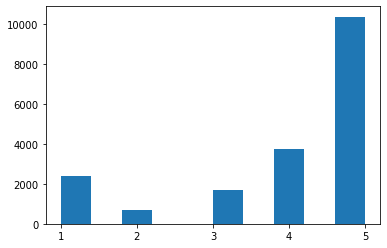

In [5]:
plt.hist(df['review_score'])
plt.xticks(np.arange(1,6))
plt.show()

In [6]:
# reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)

In [7]:
# splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

### item-based

In [8]:
# use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [9]:
# run the trained model against the testset
test_pred = algo.test(testset)
#test_pred

In [10]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2124


1.2123907430521894

In [11]:
accuracy.mse(test_pred, verbose=True)

MSE: 1.4699


1.4698913138386398

In [12]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.8776


0.8776054738944616

In [13]:
len(test_pred)

5667

In [14]:
count = 0
for i in range(len(test_pred)):
    if test_pred[i][4]['was_impossible'] == True:
        count += 1
count

4656

In [15]:
4656/5667

0.8215987294865008

### user-based

In [16]:
# use user_based true/false to switch between user-based or item-based collaborative filtering
algo2 = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo2.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [17]:
# run the trained model against the testset
test_pred2 = algo2.test(testset)
#test_pred2

In [18]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred2, verbose=True)

Item-based Model : Test Set
RMSE: 1.2052


1.2051953085409994

In [19]:
accuracy.mae(test_pred2, verbose=True)

MAE:  0.8681


0.8681141577161164

### model-based (item)

In [21]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [22]:
# First train an SVD algorithm on the dataset.
algo3 = SVD()
algo3.fit(trainset)

In [30]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo3.test(testset)

In [31]:
top_n = get_top_n(predictions, n=10)

In [32]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    pass
    #print(uid, [iid for (iid, _) in user_ratings])

### How to compute precision@k and recall@k

$Precision@k=\frac{|{Recommended items that are relevant}|}{|{Recommended items}|}$

$Recall@k=\frac{|{Recommended items that are relevant}|}{|{Relevant items}|}$

An item is considered relevant if its true rating $r_{ui}$ is greater than a given threshold. An item is considered recommended if its estimated rating $\hat{r}_{ui}$ is greater than the threshold, and if it is among the k highest estimated ratings.

In [29]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [33]:
kf = KFold(n_splits=5)
#algo3 = SVD()

In [34]:
for trainset, testset in kf.split(data):
    algo3.fit(trainset)
    predictions = algo3.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.5498489425981873
0.5497116176874485
0.5430593607305936
0.5431050228310502
0.5262940528634361
0.5259400566393959
0.5572973964063073
0.5574807480748075
0.5362159184797577
0.5358716606995318


In [35]:
# plot precision-recall curve

In [41]:
ratings_matrix = df.pivot_table(values='review_score', index='customer_unique_id', columns='product_id', fill_value=0)
ratings_matrix.head(3)

product_id,0152f69b6cf919bcdaf117aa8c43e5a2,054515fd15bc1a2029f10de97ffa9120,06c6e01186af8b98ee1fc9e01f9471e9,06edb72f1e0c64b14c5b79353f7abea3,08574b074924071f4e201e151b152b4e,0a57f7d2c983bcf8188589a5fea4a8da,0aabfb375647d9738ad0f7b4ea3653b1,0bcc3eeca39e1064258aa1e932269894,0d85c435fd60b277ffb9e9b0f88f927a,11875b30b49585209e608f40e8082e65,...,f35927953ed82e19d06ad3aac2f06353,f40876e0ef3cd5f9132b1f16b04b1346,f4f67ccaece962d013a4e1d7dc3a61f7,f71973c922ccaab05514a36a8bc741b8,f71f42e2381752836563b70beb542f80,f7a17d2c51d9df89a4f1711c4ac17f33,fb55982be901439613a95940feefd9ee,fbc1488c1a1e72ba175f53ab29a248e8,fbce4c4cb307679d89a3bf3d3bb353b9,fc1d8637c0268af3db482c14b7ef8e75
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
000ed48ceeb6f4bf8ad021a10a3c7b43,0.0,0,0,0,0,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
001926cef41060fae572e2e7b30bd2a4,0.0,0,0,0,0,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
00196c4c9a3af7dd2ad10eade69c926f,0.0,0,0,0,0,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
ratings_matrix.shape

(16443, 176)

In [43]:
X1 = ratings_matrix.T
X1.head(3)

customer_unique_id,000ed48ceeb6f4bf8ad021a10a3c7b43,001926cef41060fae572e2e7b30bd2a4,00196c4c9a3af7dd2ad10eade69c926f,001ae5a1788703d64536c30362503e49,002ae492472e45ad6ebeb7a625409392,002bdeb33da5b1b3ce8b9c822f749c82,002cdf87d4c03f08f7eb4551a923affc,002d71b244beb91ca7030b15ab526446,002ed12115742033f015cb3c269ccf68,002ef00822613c94613e60e03b169fef,...,ffe6305176b9431a3eda3cf8904d7eb7,ffe6efca3c7e6a06bad0a6a883280a93,ffe96c782a5bc522bd8bad3bc638981a,ffe9be10b9a58c5464d833e8b1b2c632,ffe9e41fbd14db4a7361347c56af5447,ffee94d548cef05b146d825a7648dab4,ffeefd086fc667aaf6595c8fe3d22d54,fff1afc79f6b5db1e235a4a6c30ceda7,ffff5962728ec6157033ef9805bacc48,ffffd2657e2aad2907e67c3e9daecbeb
product_id,,,,,,,,,,,,,,,,,,,,,
0152f69b6cf919bcdaf117aa8c43e5a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
054515fd15bc1a2029f10de97ffa9120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06c6e01186af8b98ee1fc9e01f9471e9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X1.shape

(176, 16443)

In [45]:
# decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X1)
decomposed_matrix.shape

(176, 10)

In [46]:
# correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(176, 176)

In [47]:
X1.index[75]

'6c3effec7c8ddba466d4f03f982c7aa3'

Index # of product ID purchased by customer

In [48]:
i = X1.index[75]

product_names = list(X1.index)
product_ID = product_names.index(i)
product_ID

75

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [49]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(176,)

Recommending top 25 highly correlated products in sequence

In [50]:
Recommend = list(X1.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['0aabfb375647d9738ad0f7b4ea3653b1',
 '0d85c435fd60b277ffb9e9b0f88f927a',
 '2a2d22ae30e026f1893083c8405ca522',
 '3eef0cb94ba82de806bb30ab743c7655',
 '4298b7e67dc399c200662b569563a2b2',
 '44a34214a57dc373dcd80f54c919d006',
 '5a848e4ab52fd5445cdc07aab1c40e48',
 '656e0eca68dcecf6a31b8ececfabe3e8',
 '73326828aa5efe1ba096223de496f596',
 '7e0dc102074f8285580c9777f79c90cf',
 '89b121bee266dcd25688a1ba72eefb61',
 'a9516a079e37a9c9c36b9b78b10169e8',
 'af51d485dc5255ba2e18b21b550156e6',
 'b5e13c9a353102f79c6206ff5cb61a50',
 'c4baedd846ed09b85f78a781b522f126',
 'cac9e5692471a0700418aa3400b9b2b1',
 'cd48f265a63e13b762601f5f794c5fca',
 'd017a2151d543a9885604dc62a3d9dcc',
 'd3c044bd42d84a79e3b0c42662806a48',
 'd5991653e037ccb7af6ed7d94246b249',
 'e59dd207c69d86e890febadc796d1078',
 'e9a69340883a438c3f91739d14d3a56d',
 'ee406bf28024d97771c4b1e8b7e8e219']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.

### How to get the top-N recommendations for each user